### **information about the system's block devices**

Here is a brief explanation of each column in the output:
*   **KNAME:** The kernel device name, which is used to identify the device in the Linux kernel.
*   **TYPE:** The type of block device, which can be disk, part (partition), or loop (loopback device).
*   **SIZE:** The size of the block device in bytes.
*   **MODEL:** The model name or identifier of the device, which can be useful for identifying the device's manufacturer or model number.





In [ ]:
! lsblk -io KNAME,TYPE,SIZE,MODEL #disk

KNAME TYPE  SIZE MODEL
loop0 loop   80G 
sda   disk   80G PersistentDisk  
sda1  part 75.8G 
sda2  part   16M 
sda3  part    2G 
sda4  part   16M 
sda5  part    2G 
sda6  part  512B 
sda7  part  512B 
sda8  part   16M 
sda9  part  512B 
sda10 part  512B 
sda11 part    8M 
sda12 part   32M 


#### **detailed information about the system's hardware configuration.**

In [ ]:
_ = ! apt install lshw
! lshw

c2216484cc3c
    description: Computer
    width: 64 bits
    capabilities: smp vsyscall32
  *-core
       description: Motherboard
       physical id: 0
     *-memory
          description: System memory
          physical id: 0
          size: 12GiB
     *-cpu
          product: Intel(R) Xeon(R) CPU @ 2.00GHz
          vendor: Intel Corp.
          physical id: 1
          bus info: cpu@0
          version: 6.85.3
          width: 64 bits
          capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl

##### **information about GPU**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan  9 19:19:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### **mounts the Google Drive to a Colab notebook**
*to allows access to files and folders stored in the drive*

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# root_path = 'gdrive/My Drive/your_project_folder/'  #change dir to your project folder

Mounted at /content/drive/


In [ ]:
# Full Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, add, Conv2D, PReLU, MaxPool2D, Concatenate, Dropout, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
from tensorflow.keras.models import Sequential, Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#version
print("TensorFlow version:", tf.__version__)
print("Keras version", tf.version.VERSION)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
!pip freeze | grep matplotlib==

TensorFlow version: 2.15.0


### **Dataset preparation**

Dataset: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu
<br>
<br>
Journal Method: https://arxiv.org/abs/1606.04797
<br>
<br>
Inspiration Code: https://github.com/NVIDIA/DeepLearningExamples/tree/master/TensorFlow/Segmentation/VNet

##### **Data collection**
*Downoad data from kaggle.*

In [ ]:
# Install Writer Excel
_ = ! pip install xlsxwriter

In [ ]:
EXCEL_FILENAME = "./Shuffled_COVID_QU_Ex_Dataset/Split_Data_COVID_QU_Paths.xlsx"

In [ ]:
# Get data from Kaggle
_ = ! git clone https://github.com/achmadbauravindah/ravin_kaggle_credential.git # get credential from kaggle
_ = ! pip install kaggle # install kaggle on device
_ = ! mkdir ~/.kaggle # make hidden folder .kaggle to configure credential
_ = ! cp ravin_kaggle_credential/kaggle.json ~/.kaggle/ # copy credential from github to .kaggle folder
_ = ! chmod 600 ~/.kaggle/kaggle.json # change access
_ = ! kaggle datasets download achmadbauravindah/covid-qu-dataset-1500-shuffled # which dataset to download
_ = ! unzip covid-qu-dataset-1500-shuffled # unzip if data zipped

##### **Sample Image and Mask CXR**

Sample Image CXR
Images Path: Shuffled_COVID_QU_Ex_Dataset/Covid-19/npy_images/CXR_Images_41.npy


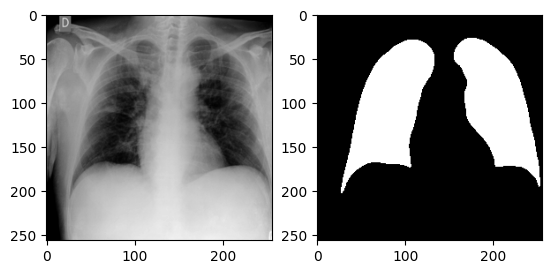

In [ ]:
import cv2

sample_image = pd.read_excel(EXCEL_FILENAME)['images_path'][0]
sample_mask = pd.read_excel(EXCEL_FILENAME)['masks_path'][0]

print("Sample Image CXR")
print("Images Path: {}".format(sample_image))

# Load the image and mask in grayscale mode
image = cv2.imread(sample_image, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(sample_mask, cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1, 2)
_ = axes[0].imshow(np.load(sample_image).reshape(256, 256), cmap='gray')
_ = axes[1].imshow(np.load(sample_mask).reshape(256, 256), cmap='gray')

plt.show()


# **Conv Block**

In [ ]:
! pip install keras_unet_collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 975.4 kB/s eta 0:00:00


In [ ]:
from __future__ import absolute_import

from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


def vnet_left(X, channel, res_num, activation='ReLU', pool=True, batch_norm=False, name='left'):
    '''
    The encoder block of 2-d V-net.

    vnet_left(X, channel, res_num, activation='ReLU', pool=True, batch_norm=False, name='left')

    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        res_num: number of convolutional layers within the residual path.
        activation: one of the `tensorflow.keras.layers` interface, e.g., 'ReLU'.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        batch_norm: True for batch normalization, False otherwise.
        name: name of the created keras layers.

    Output
    ----------
        X: output tensor.

    '''

    # Set the pool size for downsampling
    pool_size = 2

    # Encode the input with convolutional layers
    X = encode_layer(X, channel, pool_size, pool, activation=activation,
                     batch_norm=batch_norm, name='{}_encode'.format(name))

    # Apply additional convolutional layer before downsampling if pooling is enabled
    if pool is not False:
        X = CONV_stack(X, channel, kernel_size=3, stack_num=1, dilation_rate=1,
                       activation=activation, batch_norm=batch_norm, name='{}_pre_conv'.format(name))

    # Apply residual convolutional layers
    X = Res_CONV_stack(X, X, channel, res_num=res_num, activation=activation,
                       batch_norm=batch_norm, name='{}_res_conv'.format(name))

    # Return the output
    return X

def vnet_right(X, X_list, channel, res_num, activation='ReLU', unpool=True, batch_norm=False, name='right'):
    '''
    The decoder block of 2-d V-net.

    vnet_right(X, X_list, channel, res_num, activation='ReLU', unpool=True, batch_norm=False, name='right')

    Input
    ----------
        X: input tensor.
        X_list: a list of other tensors that connected to the input tensor.
        channel: number of convolution filters.
        stack_num: number of convolutional layers.
        res_num: number of convolutional layers within the residual path.
        activation: one of the `tensorflow.keras.layers` interface, e.g., 'ReLU'.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.
        batch_norm: True for batch normalization, False otherwise.
        name: name of the created keras layers.

    Output
    ----------
        X: output tensor.

    '''
    # Set the pool size for upsampling
    pool_size = 2

    # Decode the input with deconvolutional layers
    X = decode_layer(X, channel, pool_size, unpool,
                     activation=activation, batch_norm=batch_norm, name='{}_decode'.format(name))

    # Save the current state of X (skip connection)
    X_skip = X

    # Concatenate the decoded feature map with the corresponding feature maps from the left side
    X = concatenate([X,]+X_list, axis=-1, name='{}_concat'.format(name))

    # Apply residual convolutional layers
    X = Res_CONV_stack(X, X_skip, channel, res_num, activation=activation,
                       batch_norm=batch_norm, name='{}_res_conv'.format(name))

    # Return the output
    return X

def vnet_2d_base(input_tensor, filter_num, res_num_ini=1, res_num_max=3,
                 activation='ReLU', batch_norm=False, pool=True, unpool=True, name='vnet'):
    '''
    The base of 2-d V-net.

    vnet_2d_base(input_tensor, filter_num, res_num_ini=1, res_num_max=3,
                 activation='ReLU', batch_norm=False, pool=True, unpool=True, name='vnet')

    Input
    ----------
        input_tensor: the input tensor of the base, e.g., `keras.layers.Inpyt((None, None, 3))`.
        filter_num: a list that defines the number of filters for each \
                    down- and upsampling levels. e.g., `[64, 128, 256, 512]`.
                    The depth is expected as `len(filter_num)`.
        res_num_ini: number of convolutional layers of the first first residual block (before downsampling).
        res_num_max: the max number of convolutional layers within a residual block.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        batch_norm: True for batch normalization.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.
        name: prefix of the created keras layers.

    Output
    ----------
        X: output tensor.

    * This is a modified version of V-net for 2-d inputw.
    * The original work supports `pool=False` only.
      If pool is True, 'max', or 'ave', an additional conv2d layer will be applied.
    * All the 5-by-5 convolutional kernels are changed (and fixed) to 3-by-3.

    '''
    # Get the depth of the network based on the number of filter levels
    depth_ = len(filter_num)

    # determine the number of res conv layers in each down- and upsampling level
    res_num_list = []
    for i in range(depth_):
        temp_num = res_num_ini + i
        if temp_num > res_num_max:
            temp_num = res_num_max
        res_num_list.append(temp_num)

    # List to store skip connections
    X_skip = []

    # initial conv layer
    X = input_tensor
    X = CONV_stack(X, filter_num[0], kernel_size=3, stack_num=1, dilation_rate=1,
                   activation=activation, batch_norm=batch_norm, name='{}_input_conv'.format(name))

    # Initial residual convolutional layer
    X = Res_CONV_stack(X, X, filter_num[0], res_num=res_num_list[0], activation=activation,
                 batch_norm=batch_norm, name='{}_down_0'.format(name))
    X_skip.append(X)

     # Downsampling levels
    for i, f in enumerate(filter_num[1:]):
        X = vnet_left(X, f, res_num=res_num_list[i+1], activation=activation, pool=pool,
                      batch_norm=batch_norm, name='{}_down_{}'.format(name, i+1))

        X_skip.append(X)

    # Reverse the order of skip connections, filter numbers, and residual numbers for upsampling
    X_skip = X_skip[:-1][::-1]
    filter_num = filter_num[:-1][::-1]
    res_num_list = res_num_list[:-1][::-1]

    # Upsampling levels
    for i, f in enumerate(filter_num):
        X = vnet_right(X, [X_skip[i],], f, res_num=res_num_list[i],
                       activation=activation, unpool=unpool, batch_norm=batch_norm, name='{}_up_{}'.format(name, i))

    # Return the final output
    return X


def vnet_2d(input_size, filter_num, n_labels,
            res_num_ini=1, res_num_max=3,
            activation='ReLU', output_activation='Softmax',
            batch_norm=False, pool=True, unpool=True, name='vnet'):
    '''
    vnet 2d

    vnet_2d(input_size, filter_num, n_labels,
            res_num_ini=1, res_num_max=3,
            activation='ReLU', output_activation='Softmax',
            batch_norm=False, pool=True, unpool=True, name='vnet')

    Input
    ----------
        input_size: the size/shape of network input, e.g., `(128, 128, 3)`.
        filter_num: a list that defines the number of filters for each \
                    down- and upsampling levels. e.g., `[64, 128, 256, 512]`.
                    The depth is expected as `len(filter_num)`.
        n_labels: number of output labels.
        res_num_ini: number of convolutional layers of the first first residual block (before downsampling).
        res_num_max: the max number of convolutional layers within a residual block.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        output_activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interface or 'Sigmoid'.
                           Default option is 'Softmax'.
                           if None is received, then linear activation is applied.
        batch_norm: True for batch normalization.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.
        name: prefix of the created keras layers.

    Output
    ----------
        model: a keras model.

    * This is a modified version of V-net for 2-d inputw.
    * The original work supports `pool=False` only.
      If pool is True, 'max', or 'ave', an additional conv2d layer will be applied.
    * All the 5-by-5 convolutional kernels are changed (and fixed) to 3-by-3.
    '''

    # Create input layer
    IN = Input(input_size)
    X = IN

    # Base (Core) of the V-Net
    X = vnet_2d_base(X, filter_num, res_num_ini=res_num_ini, res_num_max= res_num_max,
                     activation=activation, batch_norm=batch_norm, pool=pool, unpool=unpool, name=name)
    # Output layer
    OUT = CONV_output(X, n_labels, kernel_size=1, activation=output_activation, name='{}_output'.format(name))

    # Create functional API model
    model = Model(inputs=[IN,], outputs=[OUT,], name='{}_model'.format(name))

    # Return the model
    return model

### **DSC  & IoU**

In [ ]:
def dice_coef(y_true, y_pred):
   # Flatten the true and predicted masks
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    # Calculate intersection: sum of element-wise product of flattened masks
    # |y_true| ∩ |y_pred|, Kenapa kok dikali setelah itu di sum? Karena BG nilainya 0, jadi yang diambil adalah hanya hasil segmentasi yang nilainya lebih dari 0
    intersection = K.sum(K.abs(y_true_flat * y_pred_flat))

    # Calculate union: sum of elements in both flattened masks
    # |y_true| + |y_pred|
    union = K.sum(y_true_flat) + K.sum(y_pred_flat)

    # Calculate Dice coefficient: (2 * intersection) / (union + 0.0001)
    # 0.0001 untuk mencegah nilai pembaginya 0
    dice = (2. * intersection + 0.0001) / (union + 0.0001)
    return dice

def iou(y_true, y_pred):
    # Flatten the true and predicted masks
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)

    # Calculate intersection: sum of element-wise product of flattened masks
    intersection = K.sum(K.abs(y_true_flat * y_pred_flat))

    # Calculate union: sum of elements in both flattened masks, subtract intersection
    union = K.sum(y_true_flat) + K.sum(y_pred_flat) - intersection

    # Calculate union: sum of elements in both flattened masks, subtract intersection
    iou = (intersection + 0.0001) / (union + 0.0001)
    return iou

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)



## **Build Model**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Reshape, UpSampling2D
# from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Fungsi untuk membangun arsitektur 2DVNet
def build_2dvnet(input_shape, latent_dim):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    z = Lambda(sampling)([z_mean, z_log_var])

    # Decoder
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(8*8*64, activation='relu')(decoder_input)
    x = Reshape((8, 8, 64))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    reconstructed_img = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Definisikan model
    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_input, reconstructed_img, name='decoder')
    autoencoder = Model(input_img, decoder(encoder(input_img)[2]), name='2DVNet')

    return autoencoder


### **Model Compile**

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
learning_rate = 0.0001  # Set your desired learning rate

# Membuat model menggunakan fungsi vnet_2d
model = vnet_2d((256, 256, 1), filter_num=[16, 32, 64, 128, 256], n_labels=1,
                      res_num_ini=1, res_num_max=3,
                      activation='PReLU', output_activation='Sigmoid',
                      batch_norm=True, pool=False, unpool=False, name='vnet')

# Membuat model menggunakan fungsi vnet_2d
optimizer = Adam(learning_rate=learning_rate)

# Mengompilasi model dengan konfigurasi pengoptimal, fungsi kerugian, dan metrik
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "vnet_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 vnet_input_conv_0 (Conv2D)  (None, 256, 256, 16)         144       ['input_1[0][0]']             
                                                                                                  
 vnet_input_conv_0_bn (Batc  (None, 256, 256, 16)         64        ['vnet_input_conv_0[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 vnet_input_conv_0_activati  (None, 256, 256, 16)         1048576   ['vnet_input_conv_0_b

In [ ]:
# Membuat model menggunakan fungsi build_2dvnet
input_shape = (256, 256, 1)  # Bentuk input gambar (misalnya, gambar berukuran 256x256 piksel dengan saluran tunggal)
latent_dim = 32  # Dimensi latent

model = build_2dvnet(input_shape, latent_dim)

# Menampilkan ringkasan model
model.summary()


Model: "2DVNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 encoder (Functional)        [(None, 32),              16796096  
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
 decoder (Functional)        (None, 64, 64, 1)         195329    
                                                                 
Total params: 16991425 (64.82 MB)
Trainable params: 16991425 (64.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def getArrFromExcel(sheet_name):
    images_arr = []  # List untuk menyimpan array gambar
    masks_arr = []   # List untuk menyimpan array mask
    images_path = pd.read_excel(EXCEL_FILENAME, sheet_name=sheet_name)['images_path']
    masks_path = pd.read_excel(EXCEL_FILENAME, sheet_name=sheet_name)['masks_path']

    # Iterasi melalui setiap baris di lembar excel
    for image_path, mask_path in zip(images_path, masks_path):
        # Memuat array gambar dan masker menggunakan NumPy
        images_arr.append(np.load(image_path))
        masks_arr.append(np.load(mask_path))

        # break # Hapus jika train semua data

    # Mengembalikan array NumPy dari list
    return np.array(images_arr), np.array(masks_arr)

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]

    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()

    def on_epoch_end(self, epoch, logs={}):
        # Menghitung waktu eksekusi dan menambahkannya ke dalam list logs
        self.logs.append(timer()-self.starttime)

# **Training**

In [ ]:
# Menghitung jumlah lembar (sheet) pada file Excel
n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
print("Jumlah Lembar (Sheet) pada Excel:", n_sheets_excel)

# Menghitung jumlah k-fold untuk validasi silang
n_k_fold = int((n_sheets_excel - 1) / 2)
print("Jumlah K-Fold untuk Validasi Silang:", n_k_fold)


Jumlah Lembar (Sheet) pada Excel: 11
Jumlah K-Fold untuk Validasi Silang: 5


In [ ]:
n_sheets_excel = len(pd.ExcelFile(EXCEL_FILENAME).sheet_names)
n_k_fold = int((n_sheets_excel - 1) / 2)

# Drive Path
drive_path = "/content/drive/MyDrive/190411100195-Firman Maulana/2DVNET_EP10/"

for k in range(1, n_k_fold + 1):
    print("##################### FOLD - {} #####################".format(k))

    # CALLBACK
    # CSV Logger Callback
    csv_logger_name = drive_path + 'csv_loggers/csv_logger_fold_{}.csv'.format(k)
    csv_logger_callback = CSVLogger(csv_logger_name)
    # Checkpoint Callback
    checkpoint_name = drive_path + "model_checkpoints/model_fold_{}/ModelCheckpoint-fold{}-".format(k, k) + "{epoch:02d}-{val_dice_coef:.2f}.hdf5"
    checkpoint_callback = ModelCheckpoint(checkpoint_name, save_best_only=True)
    # Timer Callback
    timer_callback = TimingCallback()

    # All Callback
    callback_list = [csv_logger_callback, timer_callback]

    # Sheet Name
    train_sheet_name_per_fold = "fold_{}_train".format(k)
    val_sheet_name_per_fold = "fold_{}_val".format(k)
    # Get Array Images and Masks
    train_images_arr, train_masks_arr = getArrFromExcel(train_sheet_name_per_fold)
    val_images_arr, val_masks_arr = getArrFromExcel(val_sheet_name_per_fold)

    # Build Model
    input_shape = train_images_arr[0].shape
    model = vnet_2d((256, 256, 1), filter_num=[16, 32, 64, 128, 256],
                    n_labels=1,
                      res_num_ini=1, res_num_max=3,
                      activation='PReLU', output_activation='Sigmoid',
                      batch_norm=True, pool=False, unpool=False, name='vnet')

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou, dice_coef])


    # Model Training
    history = model.fit(train_images_arr,
                        train_masks_arr,
                        validation_data=(val_images_arr, val_masks_arr),
                        batch_size=16,
                        epochs=10,
                        callbacks=callback_list,
                        verbose=1)  # Set verbose to 1 for printing training progress

    # Extract metrics values from the training history
    # train_loss = history.history['loss'][-1]
    train_iou = history.history['iou'][-1]
    train_dice_coef = history.history['dice_coef'][-1]

    # Print the training metrics with 5 digits after the decimal point
    print(f"Fold {k} - Train IOU: {train_iou:.5f} - Train Dice Coefficient: {train_dice_coef:.5f}")

    # Time Computation Per Fold Documentation
    excel_filename = "Training Time Computation Fold - {}.xlsx".format(k)
    time_df = pd.DataFrame({"time_computation_per_epoch":timer_callback.logs})
    with pd.ExcelWriter(drive_path + "time_computation/" + excel_filename) as writer:
        time_df.to_excel(writer)

    # Model Per Fold Documentation
    model.save(drive_path + "model_per_fold/model_fold_{}.h5".format(k))

##################### FOLD - 1 #####################
Epoch 1/10
68/68 [==============================] - 68s 486ms/step - loss: 0.2379 - iou: 0.5701 - dice_coef: 0.7150 - val_loss: 1.7796 - val_iou: 0.4029 - val_dice_coef: 0.5741
Epoch 2/10
68/68 [==============================] - 24s 350ms/step - loss: 0.0994 - iou: 0.7540 - dice_coef: 0.8593 - val_loss: 0.2969 - val_iou: 0.5397 - val_dice_coef: 0.7008
Epoch 3/10
68/68 [==============================] - 24s 351ms/step - loss: 0.0716 - iou: 0.8186 - dice_coef: 0.9001 - val_loss: 0.1967 - val_iou: 0.6121 - val_dice_coef: 0.7587
Epoch 4/10
68/68 [==============================] - 24s 353ms/step - loss: 0.0596 - iou: 0.8497 - dice_coef: 0.9186 - val_loss: 0.1559 - val_iou: 0.6762 - val_dice_coef: 0.8063
Epoch 5/10
68/68 [==============================] - 23s 344ms/step - loss: 0.0475 - iou: 0.8772 - dice_coef: 0.9345 - val_loss: 0.1260 - val_iou: 0.7605 - val_dice_coef: 0.8636
Epoch 6/10
68/68 [==============================] - 24s 354ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##################### FOLD - 2 #####################
Epoch 1/10
68/68 [==============================] - 48s 376ms/step - loss: 0.2090 - iou: 0.6055 - dice_coef: 0.7419 - val_loss: 0.5670 - val_iou: 0.4013 - val_dice_coef: 0.5725
Epoch 2/10
68/68 [==============================] - 24s 353ms/step - loss: 0.0907 - iou: 0.7854 - dice_coef: 0.8795 - val_loss: 0.4448 - val_iou: 0.3404 - val_dice_coef: 0.5065
Epoch 3/10
68/68 [==============================] - 25s 362ms/step - loss: 0.0658 - iou: 0.8390 - dice_coef: 0.9123 - val_loss: 0.5230 - val_iou: 0.3011 - val_dice_coef: 0.4602
Epoch 4/10
68/68 [==============================] - 24s 358ms/step - loss: 0.0560 - iou: 0.8622 - dice_coef: 0.9259 - val_loss: 0.2743 - val_iou: 0.5721 - val_dice_coef: 0.7269
Epoch 5/10
68/68 [==============================] - 24s 350ms/step - loss: 0.0457 - iou: 0.8865 - dice_coef: 0.9397 - val_loss: 0.2154 - val_iou: 0.6630 - val_dice_coef: 0.7964
Epoch 6/10
68/68 [==============================] - 24s 351ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##################### FOLD - 3 #####################
Epoch 1/10
68/68 [==============================] - 49s 380ms/step - loss: 0.4092 - iou: 0.3719 - dice_coef: 0.5314 - val_loss: 6.5016 - val_iou: 0.2628 - val_dice_coef: 0.4161
Epoch 2/10
68/68 [==============================] - 24s 353ms/step - loss: 0.1515 - iou: 0.6583 - dice_coef: 0.7931 - val_loss: 1.3824 - val_iou: 0.2523 - val_dice_coef: 0.4028
Epoch 3/10
68/68 [==============================] - 24s 350ms/step - loss: 0.1014 - iou: 0.7557 - dice_coef: 0.8606 - val_loss: 0.4872 - val_iou: 0.3850 - val_dice_coef: 0.5551
Epoch 4/10
68/68 [==============================] - 24s 349ms/step - loss: 0.0773 - iou: 0.8096 - dice_coef: 0.8947 - val_loss: 0.2729 - val_iou: 0.5098 - val_dice_coef: 0.6741
Epoch 5/10
68/68 [==============================] - 24s 351ms/step - loss: 0.0692 - iou: 0.8311 - dice_coef: 0.9076 - val_loss: 0.5705 - val_iou: 0.4716 - val_dice_coef: 0.6399
Epoch 6/10
68/68 [==============================] - 25s 362ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##################### FOLD - 4 #####################
Epoch 1/10
68/68 [==============================] - 46s 380ms/step - loss: 0.1767 - iou: 0.6359 - dice_coef: 0.7635 - val_loss: 1.0623 - val_iou: 0.2547 - val_dice_coef: 0.4057
Epoch 2/10
68/68 [==============================] - 25s 364ms/step - loss: 0.0824 - iou: 0.8104 - dice_coef: 0.8949 - val_loss: 0.9038 - val_iou: 0.2807 - val_dice_coef: 0.4382
Epoch 3/10
68/68 [==============================] - 24s 349ms/step - loss: 0.0625 - iou: 0.8543 - dice_coef: 0.9213 - val_loss: 0.8659 - val_iou: 0.3090 - val_dice_coef: 0.4717
Epoch 4/10
68/68 [==============================] - 24s 349ms/step - loss: 0.0579 - iou: 0.8654 - dice_coef: 0.9277 - val_loss: 0.3704 - val_iou: 0.5606 - val_dice_coef: 0.7176
Epoch 5/10
68/68 [==============================] - 24s 361ms/step - loss: 0.0496 - iou: 0.8823 - dice_coef: 0.9374 - val_loss: 0.1948 - val_iou: 0.7147 - val_dice_coef: 0.8330
Epoch 6/10
68/68 [==============================] - 24s 350ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##################### FOLD - 5 #####################
Epoch 1/10
68/68 [==============================] - 46s 370ms/step - loss: 0.2663 - iou: 0.5440 - dice_coef: 0.6884 - val_loss: 0.8961 - val_iou: 0.4369 - val_dice_coef: 0.6077
Epoch 2/10
68/68 [==============================] - 24s 353ms/step - loss: 0.1029 - iou: 0.7562 - dice_coef: 0.8609 - val_loss: 0.3636 - val_iou: 0.5466 - val_dice_coef: 0.7064
Epoch 3/10
68/68 [==============================] - 24s 360ms/step - loss: 0.0749 - iou: 0.8150 - dice_coef: 0.8979 - val_loss: 0.2540 - val_iou: 0.5373 - val_dice_coef: 0.6980
Epoch 4/10
68/68 [==============================] - 24s 348ms/step - loss: 0.0625 - iou: 0.8433 - dice_coef: 0.9149 - val_loss: 0.4065 - val_iou: 0.3932 - val_dice_coef: 0.5620
Epoch 5/10
68/68 [==============================] - 24s 351ms/step - loss: 0.0510 - iou: 0.8711 - dice_coef: 0.9310 - val_loss: 0.2116 - val_iou: 0.6579 - val_dice_coef: 0.7930
Epoch 6/10
68/68 [==============================] - 24s 351ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Evaluate the model**

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.model_selection import KFold

DRIVE_PATH = "/content/drive/MyDrive/190411100195-Firman Maulana/2DVNET_EP10/"
n_folds = 5

# Get the test sheet name
test_sheet_name = "test"

# Get the test images and masks once (assuming they are the same for all folds)
test_images_arr, test_masks_arr = getArrFromExcel(test_sheet_name)

# Initialize variables to track the best fold and its metrics
best_fold = None
best_dice_coef = 0.0  # Assuming higher Dice Coef is better
best_iou = 0.0       # Assuming higher IOU is better

# Perform k-fold cross-validationa
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
for fold, (train_index, val_index) in enumerate(kf.split(range(len(test_images_arr)))):
    # Split the data into training and validation sets
    train_images, val_images = test_images_arr[train_index], test_images_arr[val_index]
    train_masks, val_masks = test_masks_arr[train_index], test_masks_arr[val_index]

    # Load the trained model for the current fold
    model_path = DRIVE_PATH + "model_per_fold/model_fold_{}.h5".format(fold + 1)
    model = load_model(model_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'iou_loss': iou_loss,
                                                   'dice_coef': dice_coef, 'iou': iou})

    # Evaluate the model on the validation data for the current fold
    evaluation = model.evaluate(val_images, val_masks)

    # Print the evaluation metrics for the current fold
    print("\nFold {}: ".format(fold + 1))
    print("Validation IOU: {:.5f}".format(evaluation[1]))
    print("Validation Dice Coefficient: {:.5f}".format(evaluation[2]))

    # Update the best fold if the current fold has a higher Dice Coef
    if evaluation[2] > best_dice_coef:
        best_fold = fold + 1
        best_dice_coef = evaluation[2]
        best_iou = evaluation[1]

1/1 [==============================] - 13s 13s/step - loss: 0.0387 - iou: 0.9101 - dice_coef: 0.9529

Fold 1: 
Validation IOU: 0.91007
Validation Dice Coefficient: 0.95292
1/1 [==============================] - 1s 1s/step - loss: 0.0467 - iou: 0.9086 - dice_coef: 0.9521

Fold 2: 
Validation IOU: 0.90856
Validation Dice Coefficient: 0.95209
1/1 [==============================] - 1s 1s/step - loss: 0.0773 - iou: 0.8558 - dice_coef: 0.9223

Fold 3: 
Validation IOU: 0.85581
Validation Dice Coefficient: 0.92230
1/1 [==============================] - 1s 1s/step - loss: 1.2314 - iou: 0.3897 - dice_coef: 0.5609

Fold 4: 
Validation IOU: 0.38975
Validation Dice Coefficient: 0.56089


1/1 [==============================] - 1s 1s/step - loss: 0.0432 - iou: 0.9032 - dice_coef: 0.9492

Fold 5: 
Validation IOU: 0.90324
Validation Dice Coefficient: 0.94916


In [ ]:
# Print the results of the best fold
print("\nBest Fold: {}".format(best_fold))
print("Best Validation IOU: {:.5f}".format(best_iou))
print("Best Validation Dice Coefficient: {:.5f}".format(best_dice_coef))



Best Fold: 1
Best Validation IOU: 0.91007
Best Validation Dice Coefficient: 0.95292


# **Testing**

5/5 [==============================] - 1s 224ms/step


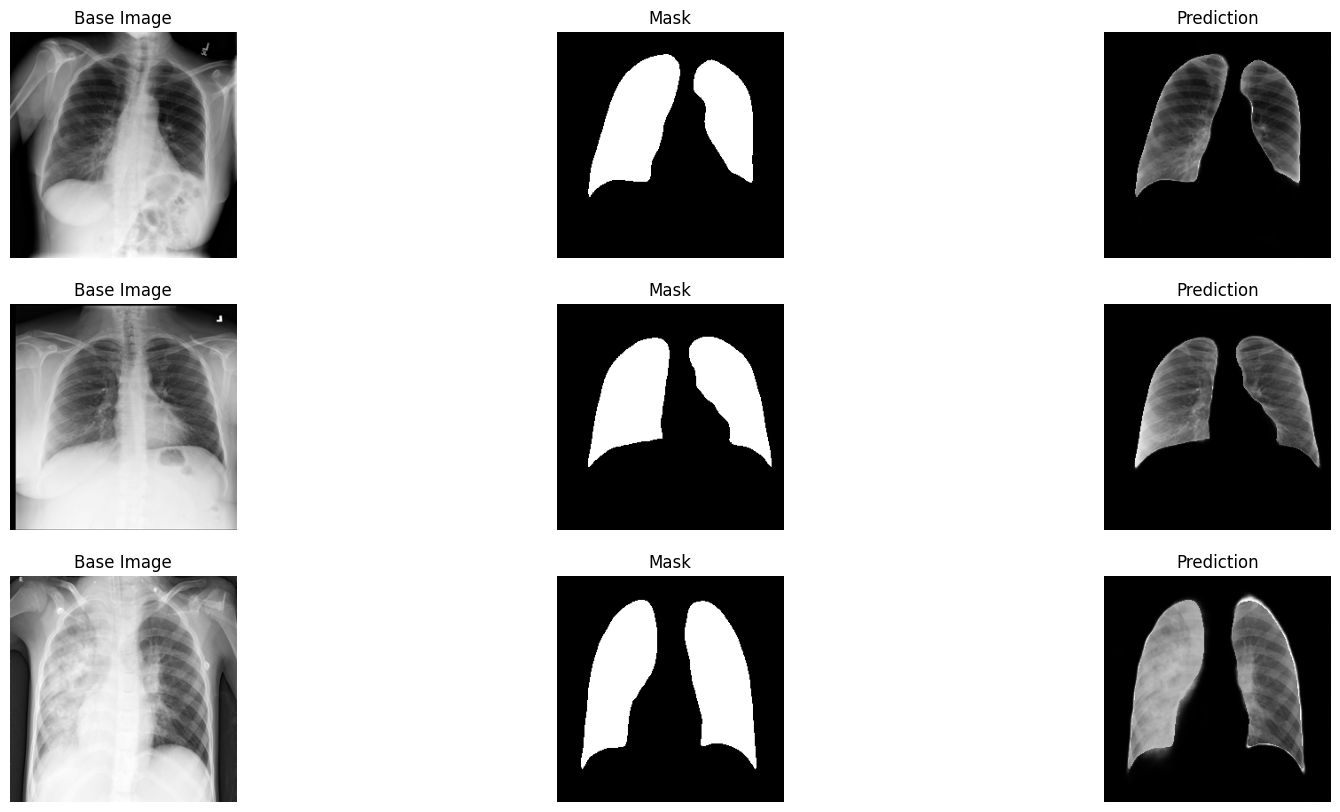

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prediksi menggunakan model
pred_candidates = np.random.randint(1, test_images_arr.shape[0], 10)
preds = model.predict(test_images_arr)

plt.figure(figsize=(20, 10))

for i in range(0, 9, 3):
    plt.subplot(3, 3, i + 1)
    plt.title("Base Image")
    plt.imshow(np.squeeze(test_images_arr[pred_candidates[i]]), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 3, i + 2)
    plt.title("Mask")
    plt.imshow(np.squeeze(test_masks_arr[pred_candidates[i]]), cmap='gray')
    plt.axis('off')

    plt.subplot(3, 3, i + 3)
    plt.title("Prediction")
    # Menggabungkan base image dengan mask
    base_image = np.squeeze(test_images_arr[pred_candidates[i]])
    mask = np.squeeze(test_masks_arr[pred_candidates[i]])
    prediction = np.squeeze(preds[pred_candidates[i]])

    # Filter hasil prediksi dengan mask
    masked_prediction = np.where(mask > 0.5, base_image, prediction)

    plt.imshow(masked_prediction, cmap='gray')
    plt.axis('off')

plt.show()


In [ ]:
__